In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


below the subplot (3,4,i+1) is to mention the output images are in 3 row and 4 column and the take(1)is refers to the first batch of the dataset which contain the batch size is 32 as mentioned earlier

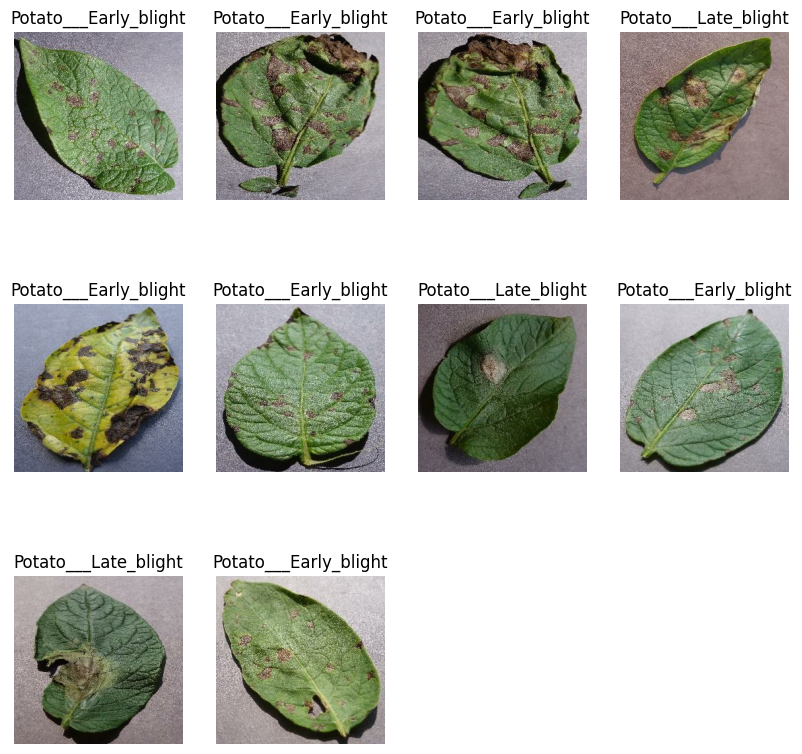

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

above the assert line is for safety check that is 100% of data is used or not,and seed ensures the shuffle is reproducible and the val_ds is validation that is used to tune our model

In [15]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

cache-keeps the dataset in memory after the first epoch,so from 2nd epoch tf wont reed images from disk again
shuffle-randomly shuffle 1000 element
prefetch-while model is training on bbatch 1,it load batch 2 in background
buffer size -no.of.elements that tf keeps ready in memory
autotune-tf automatically decides the best buffersize for your system

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation is needed when we have less data,this boost accuracy

In [21]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds=train_ds.map(
    lambda x,y : (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

above x is images and y is labels

we are going to use Convolutional Neural Network (CNN) best for image classification tasks

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 175s 3s/step - loss: 0.8977 - accuracy: 0.4948 - val_loss: 0.7680 - val_accuracy: 0.6522
Epoch 2/10
54/54 [==============================] - 124s 2s/step - loss: 0.5722 - accuracy: 0.7558 - val_loss: 0.4099 - val_accuracy: 0.8241
Epoch 3/10
54/54 [==============================] - 118s 2s/step - loss: 0.3772 - accuracy: 0.8438 - val_loss: 0.3096 - val_accuracy: 0.8715
Epoch 4/10
54/54 [==============================] - 184s 3s/step - loss: 0.2851 - accuracy: 0.8929 - val_loss: 0.1945 - val_accuracy: 0.9248
Epoch 5/10
54/54 [==============================] - 127s 2s/step - loss: 0.2388 - accuracy: 0.9062 - val_loss: 0.2295 - val_accuracy: 0.9028
Epoch 6/10
54/54 [==============================] - 117s 2s/step - loss: 0.2338 - accuracy: 0.9062 - val_loss: 0.1629 - val_accuracy: 0.9300
Epoch 7/10
54/54 [==============================] - 115s 2s/step - loss: 0.1950 - accuracy: 0.9225 - val_loss: 0.1533 - val_accuracy: 0.9311
Epoch 8/10
54

In [27]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 11s 399ms/step - loss: 0.1963 - accuracy: 0.9219


In [28]:
scores

[0.19633585214614868, 0.921875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


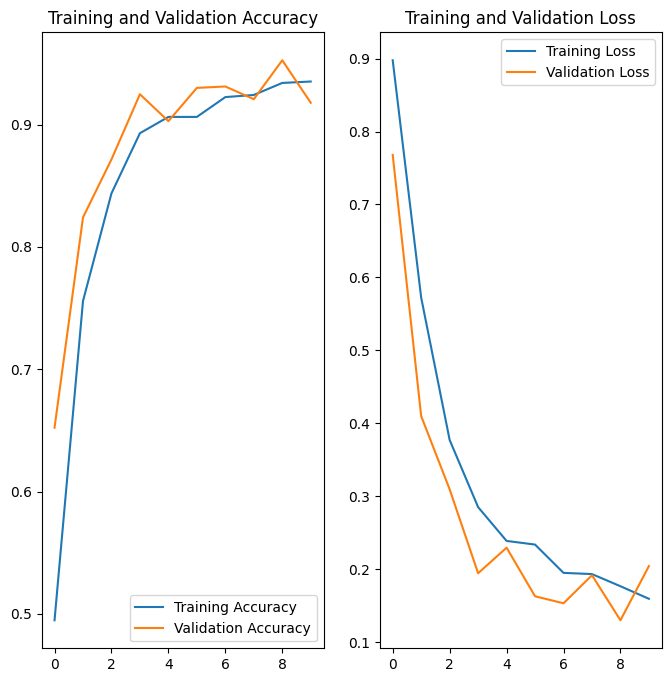

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to preedict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 623ms/step
predicted label: Potato___Early_blight


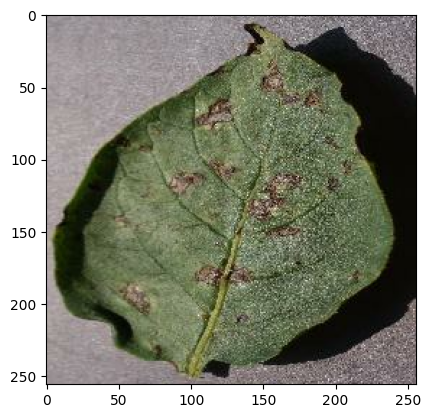

In [34]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):

    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("first image to preedict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(Image[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    prediction=model.predict(img_array)
    predicted_class=class_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 35ms/step


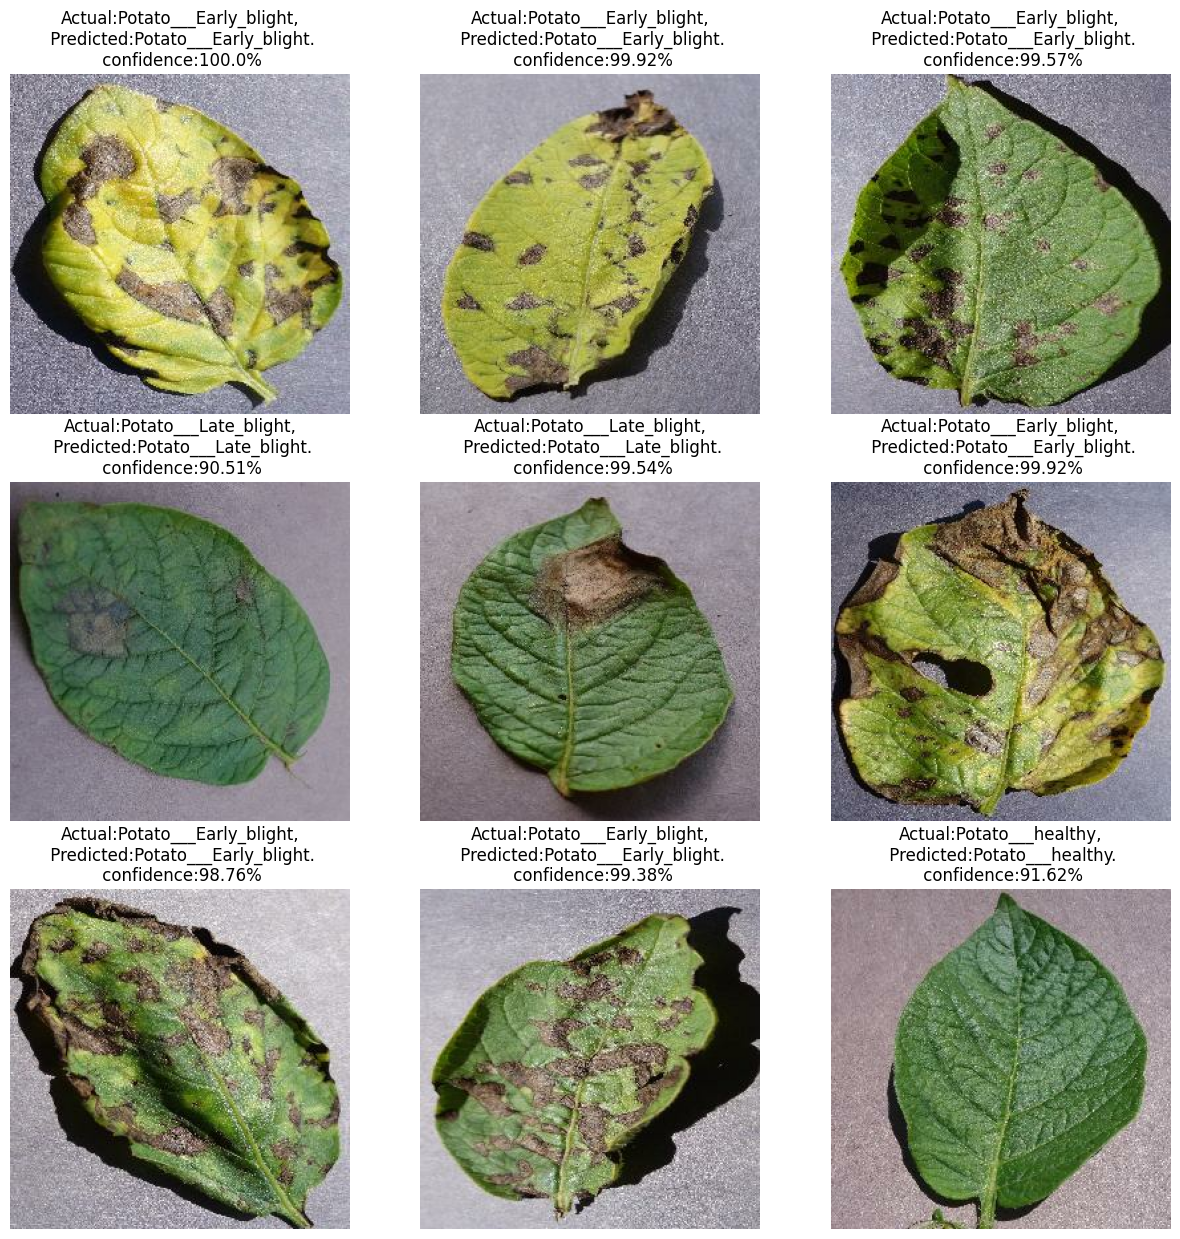

In [45]:
plt.figure(figsize=(15,15))
for Image,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(Image[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,Image[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis("off")

In [47]:
model.save("potato_disease_model.h5")
